In [34]:
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import json
import http

def companies_list():
    symb=[]
    with open('nasdaq-company-list.csv', newline='') as csvfile:
        reader=csv.DictReader(csvfile)
        for row in reader:
            symb.append(row['Symbol'])
        return symb[:101]
    

def get_timeseries(symbol):
    conec = http.client.HTTPSConnection('www.alphavantage.co', timeout = 10)
    conec.request("GET", '/query?function=TIME_SERIES_WEEKLY&symbol='+symbol+'&interval=5min&apikey=07THEOFGYUDV073A')
    resp=conec.getresponse()
    return json.loads(resp.read().decode('utf8'))

#for trainning
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import keras
import csv
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Convolution1D, Flatten, MaxPooling1D
import datetime as dt
import urllib.request, json
import os
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from alphavantage import time_series_weekly

# variables: '1. open', '2. high', '3. low', '4. close'
# Make plots bigger
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

close=[]
test=[]
low=[]
high=[]
for timestamp, data in jro['Weekly Time Series'].items():
    highs = float(data['2. high'])
    lows = float(data['3. low'])
    clos=float(data['4. close'])
    close.insert(0, clos)
    low.insert(0, lows)
    high.insert(0, highs)
    #print(timestamp) -> from 2019 to begining
    #]\\print(test)

def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential((
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'),
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model


def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q


def evaluate_timeseries(timeseries, window_size):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       #1D vectors -> 2D column vectors

    nb_samples, nb_series = timeseries.shape
   # model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)

    #model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    test_size = int(0.2 * nb_samples)
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=1, batch_size=2, validation_data=(X_test, y_test))

    print(type(model))
    pred = model.predict(X_test)
   # print('\n\nactual', 'predicted', sep='\t')
    #for actual, predicted in zip(y_test, pred.squeeze()):
     #   print(actual.squeeze(), predicted, sep='\t')
    print('next', model.predict(q).squeeze(), sep='\t')
    return model.predict(q)


#def company()
def load_json():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model=model_from_json(loaded_model_json)
    loaded_model.load_weights("model.h5")
    return loaded_model

def predict(loaded_model, symbol):
    t=time_series_weekly(symbol)
    inTimeseries = []
    for timestamp, data in t.items():
        clos=float(data['4. close'])
        inTimeseries.insert(0, clos)
    print(inTimeseries)
    return loaded_model.predict(np.atleast_3d(inTimeseries))
#company_list=pd.read_csv("nasdaq-company-list.csv")
#print(company_list)

    
def main():
    """Prepare input data, build model, evaluate."""
    np.set_printoptions(threshold=25)
    companies=companies_list()
    model = make_timeseries_regressor(1043, 4, nb_input_series=1, nb_outputs=1, nb_filter=4)
    for symbol in companies:
        jro = get_timeseries(symbol)
        #ts_length = len(jro['Weekly Time Series'].items())
        #window_size = int(0.2*(ts_length))
        #timeseries = np.arange(ts_length)
        filter_length=4
        print(predict(model, symbol))
    modelJson = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(modelJson)
    model.save_weights("model.h5")
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model=model_from_json(loaded_model_json)
    loaded_model.load_weights("model.h5")
    
main()

C:\Users\Radu\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(1043, 1), filters=4, kernel_size=4)`
C:\Users\Radu\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=4, kernel_size=4)`


[13.563, 15.5, 15.813, 13.375, 12.438, 12.375, 10.688, 12.438, 10.75, 10.813, 10.5, 11.688, 11.688, 10.688, 9.188, 8.188, 7.031, 6.813, 7.875, 7.125, 6.0, 4.75, 4.5, 5.875, 7.25, 7.0, 6.938, 6.438, 5.063, 5.5, 5.563, 5.625, 5.125, 5.813, 5.625, 5.75, 5.938, 5.625, 5.25, 4.688, 5.063, 5.688, 5.625, 5.75, 5.438, 4.984, 4.625, 4.188, 4.063, 3.75, 3.516, 2.875, 3.75, 3.938, 3.563, 3.75, 4.031, 4.438, 4.125, 4.813, 4.875, 4.938, 5.5, 6.219, 6.0, 6.0, 6.0, 5.938, 6.0, 6.0, 6.063, 8.0, 6.734, 6.15, 7.6, 8.2, 9.05, 8.9, 9.4, 9.89, 9.85, 10.4, 10.91, 11.67, 14.84, 13.0, 13.3, 13.08, 12.22, 11.95, 12.98, 12.8, 12.82, 12.8, 12.8, 10.5, 10.01, 12.06, 12.0, 12.0, 10.95, 9.87, 10.61, 10.47, 11.96, 12.97, 14.46, 15.0, 14.85, 16.03, 15.73, 17.11, 12.87, 13.19, 13.75, 13.35, 12.05, 11.96, 13.05, 13.1, 13.6, 13.29, 13.56, 13.62, 13.0, 13.52, 13.721, 13.38, 14.0, 13.391, 13.009, 11.6, 11.24, 10.88, 10.5, 10.3, 11.16, 10.2, 9.79, 10.08, 8.55, 5.941, 6.6, 6.88, 7.94, 9.9, 8.34, 8.56, 6.72, 7.11, 6.04, 6.34

KeyError: 'Weekly Time Series'

<class 'pandas.core.frame.DataFrame'>


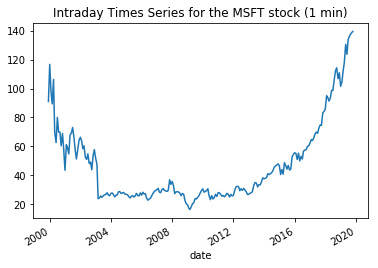

In [5]:
#ts = TimeSeries(key='07THEOFGYUDV073A', output_format='pandas')

window_size=100
N=training_data.size
avg_predictions=[]
avg_x=[]
for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = jro.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = jro.loc[pred_idx,'']

    avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((avg_predictions[-1]-training_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE predic %.5f'%(0.5*np.mean(mse_errors)))






In [ ]:
#main
print("Close value")
    print('\nSimple single timeseries vector prediction')
                # The timeseries f(t) = t
    evaluate_timeseries(mid, window_size)

    print('\nMultiple-input, multiple-output prediction')
    timeseries = np.array([np.arange(ts_length), -np.arange(ts_length)]).T      # The timeseries f(t) = [t, -t]
    evaluate_timeseries(mid, window_size)
    
    print("Low value")
    print('\nSimple single timeseries vector prediction')
    timeseries = np.arange(ts_length)                   # The timeseries f(t) = t
    evaluate_timeseries(low, window_size)

    print('\nMultiple-input, multiple-output prediction')
    timeseries = np.array([np.arange(ts_length), -np.arange(ts_length)]).T      # The timeseries f(t) = [t, -t]
    evaluate_timeseries(low, window_size)
    
    print("High Value")
    print('\nSimple single timeseries vector prediction')
    timeseries = np.arange(ts_length)                   # The timeseries f(t) = t
    evaluate_timeseries(high, window_size)

    print('\nMultiple-input, multiple-output prediction')
    timeseries = np.array([np.arange(ts_length), -np.arange(ts_length)]).T      # The timeseries f(t) = [t, -t]
    evaluate_timeseries(high, window_size)
    

In [4]:
#EMA = 0.0
#gamma = 0.1
#for ti in range(11000):
 # EMA = gamma*train_reshape[ti] + (1-gamma)*EMA
  #train_reshape[ti] = EMA